# Applying machine learning algorithms on MIMIC

## Patient Monitoring and Decision Support using Health Data

**Notebook by Olivier Nguyen (Github: [olinguyen](http://github.com/olinguyen))**

### Introduction

Everyday, the healthcare industry creates large amounts of patient and clinical data and stores them in electronic health records. Most of this data has previously been inaccessible, in part due to patient privacy concerns, which poses a challenge to researchers working on the analysis of health records.

However, initatives like the Medical Information Mart For Intensive Care (MIMIC) database project have allowed for everyone to use and experiment with health data. In particular, the MIMIC database is a critical care database made freely available for researchers around the world to develop and evaluate intensive care unit (ICU) patient monitoring and decision support systems that will improve the efficiency, accuracy and timeliness of clinical decision-making in critical care.

### Objective

In the [previous notebook](https://github.com/olinguyen/gsoc2017-shogun-dataproject/blob/master/Exploring MIMIC.ipynb), we were introduced to the MIMIC database to better understand the dataset and visualize its contents. In this notebook, we'll dive into the data analysis component of this project. Let's recall the main objective of this data project which are to perform:

* (1) mortality prediction
* (2) length of stay

More specifically, we'll focus on learning how to:

* Extract predictor variables from the MIMIC database
* Build machine learning models for the predictions tasks
* Evaluate and compare the performance of various algorithms


## Features extraction

Predictors from three main categories were extracted: demographic information, vital sign data and laboratory measurements. These were selected as the most relevant information in determining the likelihood of mortality and hospital length of stay.

| Demographic & Clinical Info             | Description |
|-------------------------|---------------------------------------------|
| Age                     | Age of the patient upon entering the ICU    |
| Gender                  | Patient gender (male or female)             |
| Hospital length of stay | Number of days spent in the hospital        |
| ICU length of stay      | Number of days spent in the ICU             |
| First care unit         | ICU type in which the patient was cared for |
| Admission type          | Admission type the patient entered          |

Vital signs are clinical measurements that describe the state of a patient's body functions.

| Vital sign               | Description |
|--------------------------|-------------|
| Heart Rate               | Heartbeat rate of the patient |
| Mean Blood Pressure      | Average pressure in a patient's arteries during one cardiac cycle       |
| Diastolic blood pressure | Pressure when the heart is at rest between beats            |
| Systolic blood pressure  | Pressure when the heart is beating |
| Respiratory Rate         | Number of breaths taken per minute       |
| Temperature              | Temperature of a patient in degrees Celcius            |
| SpO2                     | Amount of oxygen in the blood            |
| Glasgow Coma Scale       | Scoring system used to describe the level of consciousness in a person            |
| Ventilation              | Whether the patient was ventilated or not            |
| Urine output             | How much urine was produced            |

Laboratory measurements are made by acquiring a fluid from the patient's body (e.g. blood from an arterial line or urine from a [catheter](https://en.wikipedia.org/wiki/Catheter)) and then analyzing it in the laboratory.

| Laboratory measurements |
|-------------------------|
| Aniongap                |
| Bicarbonate             |
| Creatinine              |
| Chloride                |
| Glucose                 |
| Hematocrit              |
| Hemoglobin              |
| Platelet                |
| Potassium               |
| Sodium                  |
| Blood urea nitrogen     |
| White blood cells       |

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from scipy.stats import ks_2samp
from scipy import interp
from modshogun import *
#from sklearn.svm import SVC, LinearSVC
#from sklearn.linear_model import LogisticRegression
import time

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

#from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# SQL database config
sqluser = ''
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = ''
port = 5432
pwd = getpass.getpass()

········


In [35]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [120]:
query = \
"""
-- Table #3: Services
with serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)

-- Table #4: Clinical data + demographics
, co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit, admission_type
, icu.los as icu_los
, round((EXTRACT(EPOCH FROM (adm.dischtime-adm.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age_icu_in
, pat.gender
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
, hospital_expire_flag
, CASE WHEN pat.dod IS NOT NULL 
       AND pat.dod >= icu.intime - interval '6 hour'
       AND pat.dod <= icu.outtime + interval '6 hour' THEN 1 
       ELSE 0 END AS icu_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '30' day THEN 1 
    ELSE 0 END as hospital30day_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '1' year THEN 1 
    ELSE 0 END as hospital1year_expire_flag      
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm
ON adm.hadm_id = icu.hadm_id    
)

-- Table #5: Exclusions
, excl AS
(
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_los, co.hosp_los
  , co.age_icu_in
  , co.gender
  , co.icustay_id_order
  , serv.curr_service
  , co.first_careunit
  , co.hospital_expire_flag
  , co.icu_expire_flag
  , CASE
        WHEN co.icu_los < 1 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age_icu_in < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
)

SELECT vital.icustay_id, vital.subject_id, vital.hadm_id
-- vital signs for the first 24 hours of the icu stay
, HeartRate_Min
, HeartRate_Mean
, HeartRate_Max
, DiasBP_Min
, DiasBP_Max
, SysBP_Min
, SysBP_Max
, MeanBP_Min
, MeanBP_Mean
, MeanBP_Max
, RespRate_Min
, RespRate_Mean
, RespRate_Max
, TempC_Min
, TempC_Max
, SpO2_Min
, SpO2_Max

-- Glasgow coma score
, MinGCS
, GCSMotor
, GCSVerbal
, GCSEyes

-- lab values
, ANIONGAP_min
, ANIONGAP_max
, ALBUMIN_min
, ALBUMIN_max
, BANDS_min
, BANDS_max
, BICARBONATE_min
, BICARBONATE_max
, BILIRUBIN_min
, BILIRUBIN_max
, CREATININE_min
, CREATININE_max
, CHLORIDE_min
, CHLORIDE_max
, lab.GLUCOSE_min
, lab.GLUCOSE_max
, HEMATOCRIT_min
, HEMATOCRIT_max
, HEMOGLOBIN_min
, HEMOGLOBIN_max
, LACTATE_min
, LACTATE_max
, PLATELET_min
, PLATELET_max
, POTASSIUM_min
, POTASSIUM_max
, PTT_min
, PTT_max
, INR_min
, INR_max
, PT_min
, PT_max
, SODIUM_min
, SODIUM_max
, BUN_min
, BUN_max
, WBC_min
, WBC_max

, urineoutput

-- whether the patient is ventilated on the first day of the ICU stay
, vent

-- demographic data
, co.age_icu_in, co.first_careunit, co.gender, co.admission_type
, hw.height_first, hw.weight_first

-- outcomes
, co.hospital_expire_flag, co.icu_expire_flag
, co.hosp_los, co.icu_los, co.icustay_id_order
, co.hospital1year_expire_flag, hospital30day_expire_flag

-- exclusions
, excl.exclusion_los, excl.exclusion_age
, excl.exclusion_first_stay, excl.exclusion_surgical

FROM mimiciii_dev.vitalsfirstday vital
LEFT JOIN mimiciii_dev.labsfirstday lab
  ON vital.icustay_id = lab.icustay_id
LEFT JOIN mimiciii_dev.gcsfirstday gcs
  ON vital.icustay_id = gcs.icustay_id
LEFT JOIN mimiciii_dev.uofirstday uo
  ON vital.icustay_id = uo.icustay_id
LEFT JOIN mimiciii_dev.ventfirstday vent
  ON vital.icustay_id = vent.icustay_id
left join co
  ON vital.icustay_id = co.icustay_id
left join public.heightweight hw
  ON vital.icustay_id = hw.icustay_id
left join excl
  on vital.icustay_id = excl.icustay_id;
"""

query_output = pd.read_sql_query(query,con) #.dropna().reset_index(drop=True)
query_output.head()

,icustay_id,subject_id,hadm_id,heartrate_min,heartrate_mean,heartrate_max,diasbp_min,diasbp_max,sysbp_min,sysbp_max,...,icu_expire_flag,hosp_los,icu_los,icustay_id_order,hospital1year_expire_flag,hospital30day_expire_flag,exclusion_los,exclusion_age,exclusion_first_stay,exclusion_surgical
0,263738,13,143045,60.0,83.600000,124.0,53.0,84.0,102.0,151.0,...,0,6.8556,3.6660,1,0,0,0,0,0,0
1,211832,71,111944,98.0,112.444444,137.0,31.0,130.0,94.0,157.0,...,0,4.6618,2.8609,1,0,0,0,0,0,0
2,233150,78,100536,56.0,63.117647,73.0,78.0,119.0,134.0,206.0,...,0,3.9139,1.4891,1,0,0,0,0,0,0
3,233111,101,175533,72.0,87.034483,117.0,19.0,85.0,57.0,182.0,...,0,15.7785,9.8919,1,1,1,0,0,0,0
4,212246,103,130744,42.0,51.500000,60.0,40.0,71.0,112.0,161.0,...,0,7.7347,3.0237,1,1,1,0,0,0,1


In [121]:
query_output.to_csv('./full-features-materialized.csv', index=False)

### Selection Criteria

Because MIMIC is an ICU database, the focus was placed on patients admitted to and discharged from the ICU. Patients admitted to the ICU generally suffer from severe and life-threatening illnesses and injuries which require constant, close monitoring and support. Being able to make good decisions during this time period is therefore crucial. For that reason, data points were queried and grouped based off the ICU stay rather than the individual patient to develop a model specifically for ICU patient monitoring and decision-making.

The selection criteria is described below along with a short explanation. The following points were excluded from the dataset:

* Patients aged less than 16 years old
    * This also removed neonates and children, which likely have different predictors than adults
* Second admissions of patients
    * Simplifies analysis which assumes independent observations
    * We avoid taking into account that ICU stays are highly correlated
* Length of stay less than 2 days
    * Helps remove false positives that were placed in ICU for precautionary purposes

In [12]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'hospital1year_expire_flag', 'hospital30day_expire_flag']

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            
            'aniongap_min', 'aniongap_max',
            #'albumin_min', 'albumin_max',
            #'bands_min', 'bands_max',
            'bicarbonate_min', 'bicarbonate_max',
            #'bilirubin_min', 'bilirubin_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            #'lactate_min', 'lactate_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            #'ptt_min', 'ptt_max',
            #'inr_min', 'inr_max',
            #'pt_min', 'pt_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
            
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, mortality_names + feature_names][:500]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)

#query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True) # drop NaNs

outcomes = query_output.loc[:, mortality_names]
features = query_output.loc[:, query_output.columns.difference(mortality_names + los_names)]

X = features
y = outcomes['hospital_expire_flag'].replace(0, -1)

print(len(query_output))
query_output.tail()

500


,hospital_expire_flag,icu_expire_flag,hospital1year_expire_flag,hospital30day_expire_flag,age_icu_in,gender,first_careunit,admission_type,heartrate_min,heartrate_max,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
495,0,0,0,0,35.522159,1,2,1,85.0,123.0,...,3.9,4.2,138.0,143.0,12.0,15.0,18.5,22.9,0,3000.0
496,0,0,0,0,79.652547,1,1,0,67.0,117.0,...,3.2,5.5,139.0,142.0,14.0,18.0,9.5,11.5,1,4245.0
497,0,0,0,0,55.407478,1,2,1,70.0,118.0,...,3.2,3.2,141.0,141.0,3.0,3.0,3.3,3.3,0,2810.0
498,1,1,1,1,91.600000,0,0,1,59.0,72.0,...,4.7,5.6,142.0,143.0,63.0,69.0,16.3,16.3,0,154.0
499,0,0,0,0,39.850659,1,5,1,75.0,116.0,...,4.1,4.6,138.0,145.0,8.0,12.0,11.7,19.5,0,1660.0


## Data preprocessing


Because not all lab measurements are recorded for every patient, a lot missing values and NaNs were found in the dataset which were replaced with the mean value.

 Additionally, data standardization was applied to make each feature have zero mean by subtracting the mean, and have unit-variance to ensure that all the data is normalized, that the features are in the same range.

In [13]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = BinaryLabels(np.array(y[:split]))
y_test = BinaryLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 350)
('Number of testing samples:', 150)


In [14]:
preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

True

## Applying machine learning algorithms

We'll focus running various basic machine learning algorithms without any cross-validation for prototyping, then evaluate our models more thoroughly afterwards. The following classifiers will be evaluated:

* SVM
* Logistic Regression
* Decision Trees (ID3)
* Random Forest
* KNN

## SVM

In [20]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test)

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 90.13110354082792)
('Area under ROC(%):', 0.8460290297024776)
CPU times: user 4.31 s, sys: 3.9 s, total: 8.2 s
Wall time: 4.34 s


## Logistic Regression

In [135]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_LR)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

lr_roc = ROCEvaluation()
lr_roc.evaluate(y_pred, y_test)

auc = lr_roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.8314741069842869)
CPU times: user 3.2 s, sys: 3.25 s, total: 6.45 s
Wall time: 2.43 s


## Kernel SVM

In [30]:
classifier = LibLinear()
strategy = MulticlassOneVsOneStrategy()
mc_classifier = LinearMulticlassMachine(strategy, X_train, classifier, y_train)
mc_classifier.train()

y_pred = clf.apply_multiclass(X_test)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: [WARN] In file /build/shogun-v9ad6W/shogun-6.0.0+1SNAPSHOT201704270057/src/shogun/multiclass/MulticlassOneVsOneStrategy.cpp line 34: MulticlassOneVsOneStrategy::CMulticlassOneVsOneStrategy(): register parameters!

  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: [WARN] In file /build/shogun-v9ad6W/shogun-6.0.0+1SNAPSHOT201704270057/src/shogun/classifier/svm/LibLinear.cpp line 422: reaching max number of iterations
Using -s 2 may be faster(also see liblinear FAQ)


  after removing the cwd from sys.path.


In [21]:
C = 1.0

clf = MulticlassLogisticRegression(C, X_train, y_train)
clf.train()

y_pred = clf.apply_multiclass(X_test)

# Convert to BinaryLabels()
y_pred_bin = y_pred.get_labels()
y_pred_bin[y_pred_bin == 0] = -1
y_pred_bin = BinaryLabels(y_pred_bin)

y_test_bin = y_test.get_labels()
y_test_bin[y_test_bin == 0] = -1
y_test_bin = BinaryLabels(y_test_bin)

roc = ROCEvaluation()
roc.evaluate(y_pred_bin, y_test_bin)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.6105072463768116)


## Random Forest

In [16]:
%%time
y_train = MulticlassLabels(np.array(y.replace(-1, 0)[:split].astype(np.float)))
y_test = MulticlassLabels(np.array(y.replace(-1, 0)[split:].astype(np.float)))

feature_types = np.zeros_like(features.columns, dtype=bool)
feature_types[np.where( (features.columns == 'admission_type') | (features.columns == 'first_careunit') |(features.columns == 'gender'))[0]] = True
m_vote = MajorityVote()

rand_forest = RandomForest(X_train, y_train, 100)
rand_forest.set_combination_rule(m_vote)
rand_forest.set_feature_types(feature_types)
rand_forest.train()

y_pred = rand_forest.apply_multiclass(X_test)

# Convert to BinaryLabels()
y_pred_bin = y_pred.get_labels()
y_pred_bin[y_pred_bin == 0] = -1
y_pred_bin = BinaryLabels(y_pred_bin)

y_test_bin = y_test.get_labels()
y_test_bin[y_test_bin == 0] = -1
y_test_bin = BinaryLabels(y_test_bin)

roc = ROCEvaluation()
roc.evaluate(y_pred_bin, y_test_bin)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.5797101449275363)
CPU times: user 1.02 s, sys: 16 ms, total: 1.04 s
Wall time: 854 ms


## KNN

In [11]:
%%time

distance = EuclideanDistance(X_train, X_train)
k = 3
knn = KNN(k, distance, y_train)

knn.train()

y_pred = knn.apply_multiclass(X_test)

# Convert to BinaryLabels()
y_pred_bin = y_pred.get_labels()
y_pred_bin[y_pred_bin == 0] = -1
y_pred_bin = BinaryLabels(y_pred_bin)

y_test_bin = y_test.get_labels()
y_test_bin[y_test_bin == 0] = -1
y_test_bin = BinaryLabels(y_test_bin)

roc = ROCEvaluation()
roc.evaluate(y_pred_bin, y_test_bin)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.5859543104441064)
CPU times: user 6min 33s, sys: 1.47 s, total: 6min 35s
Wall time: 2min 54s


## Stratified k-fold cross validation

[Stratified 10-fold]([1]) was employed as the cross-validation technique with the area under the receiver operating characteristic curve (auROC) averaged out over all the folds. Stratified cross-validation is used because it gives a good estimate for the performance of our model, as the data is divided into k equally sized folds in such a way that labels in each partition are roughly the same. Since the number of patients who actually died is low, accuracy is not a good metric for this problem. If our classifier would never make a prediction e.g. predicting 0 for every sample, the model would still yield a high accuracy. Instead, auROC is a better fit because it looks at the true positive rate and the false positive rate.

[1]: (https://en.wikipedia.org/wiki/Cross-validation_\(statistics›)#k-fold_cross-validation)


Evaluating classifiers...
SVM
('Fold', 0, ' auROC(%): ', 0.8362963843755996)
('Fold', 1, ' auROC(%): ', 0.839726853464006)
('Fold', 2, ' auROC(%): ', 0.8355724860808302)
('Fold', 3, ' auROC(%): ', 0.8289046110464412)
('Fold', 4, ' auROC(%): ', 0.8325690767133276)
('Fold', 5, ' auROC(%): ', 0.8420737737425964)
('Fold', 6, ' auROC(%): ', 0.8273180509431723)
('Fold', 7, ' auROC(%): ', 0.8092518197028787)
('Fold', 8, ' auROC(%): ', 0.8484367966434081)
('Fold', 9, ' auROC(%): ', 0.8385052570302208)
('Mean auROC across all folds for', 'SVM', ':', 0.8338655109742481)
LR
('Fold', 0, ' auROC(%): ', 0.836017802087655)
('Fold', 1, ' auROC(%): ', 0.8390185070367391)
('Fold', 2, ' auROC(%): ', 0.8367716370581115)
('Fold', 3, ' auROC(%): ', 0.8299450479450147)
('Fold', 4, ' auROC(%): ', 0.8325843958883327)
('Fold', 5, ' auROC(%): ', 0.8422559017121853)
('Fold', 6, ' auROC(%): ', 0.8278650234841343)
('Fold', 7, ' auROC(%): ', 0.8102939552739339)
('Fold', 8, ' auROC(%): ', 0.8490500174113808)
('Fold',

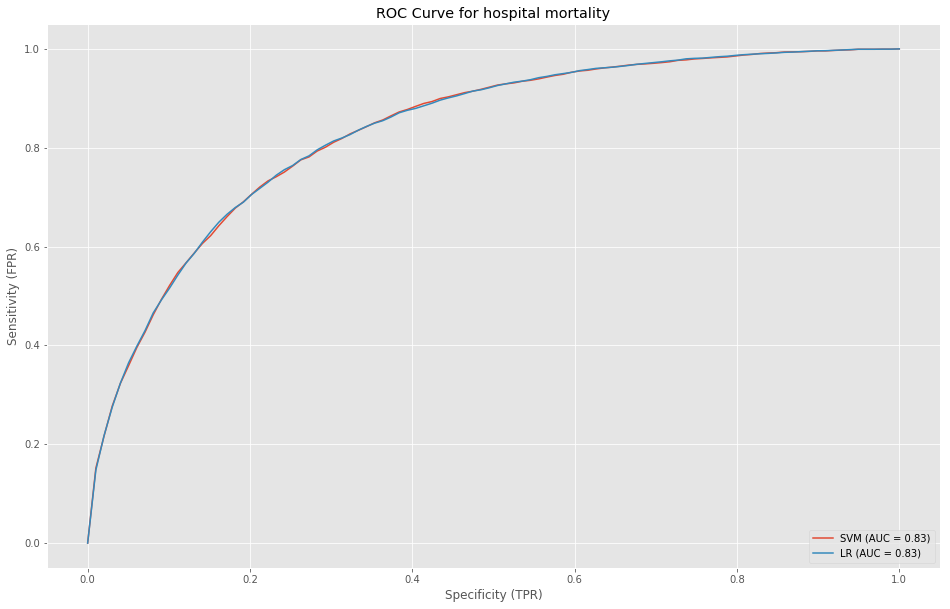

CPU times: user 50.6 s, sys: 53.6 s, total: 1min 44s
Wall time: 39.2 s


In [60]:
%%time

features = RealFeatures(np.array(X))
labels = BinaryLabels(np.array(y))

# Parameters to svm
C = 0.1
epsilon = 0.001

k = 10
stratified_split = StratifiedCrossValidationSplitting(labels, k)

metric = ROCEvaluation()

stratified_split.build_subsets()
results = {}
total_results = {}

classifiers = {"LR": L2R_LR, "SVM": L2R_L2LOSS_SVC }#, "RBF": None } #,"LR": L2R_LR}
print("Evaluating classifiers...")

mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(16, 10))

y = outcomes['hospital30day_expire_flag'].replace(0, -1)

for clf in classifiers:
    aucs = []
    print(clf)
    mean_tpr = 0.0
    for i in range(k):
        train_idx = stratified_split.generate_subset_inverse(i)
        test_idx = stratified_split.generate_subset_indices(i)
        X_train = RealFeatures(np.array(X.loc[train_idx]).T)
        y_train = BinaryLabels(np.array(y.loc[train_idx]))    

        X_test = RealFeatures(np.array(X.loc[test_idx]).T)
        y_test = BinaryLabels(np.array(y.loc[test_idx]))

        preprocessor = PruneVarSubMean(True)
        preprocessor.init(X_train)
        X_train.add_preprocessor(preprocessor)
        X_train.apply_preprocessor(True)

        preprocessor.init(X_test)
        X_test.add_preprocessor(preprocessor)
        X_test.apply_preprocessor(True)            

        if clf == "RBF":
            gauss_kernel = GaussianKernel(X_train, X_train, 15)
            svm = LibSVM(C, gauss_kernel, y_train)
            svm.set_epsilon(epsilon)

        else:
            svm = LibLinear(C, X_train, y_train)
            svm.set_liblinear_solver_type(classifiers[clf])
            svm.set_epsilon(epsilon)

        svm.train()

        y_pred = svm.apply(X_test)

        roc = ROCEvaluation()
        roc.evaluate(y_pred, y_test)

        auc = roc.get_auROC()
        print("Fold", i, " auROC(%): ", auc)    
        aucs.append(auc)

        fpr, tpr = roc.get_ROC()
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

    results[clf] = aucs
    print("Mean auROC across all folds for", clf, ":", np.mean(aucs))
    mean_tpr /= k
    mean_tpr[-1] = 1.0


    plt.plot(mean_fpr, mean_tpr, label='%s (AUC = %0.2f)' % (clf, np.mean(aucs)))

plt.title('ROC Curve for hospital mortality')
plt.xlabel('Specificity (TPR)')
plt.ylabel('Sensitivity (FPR)')
    
plt.legend(loc='lower right')
plt.rc('font', size=18)

plt.show()

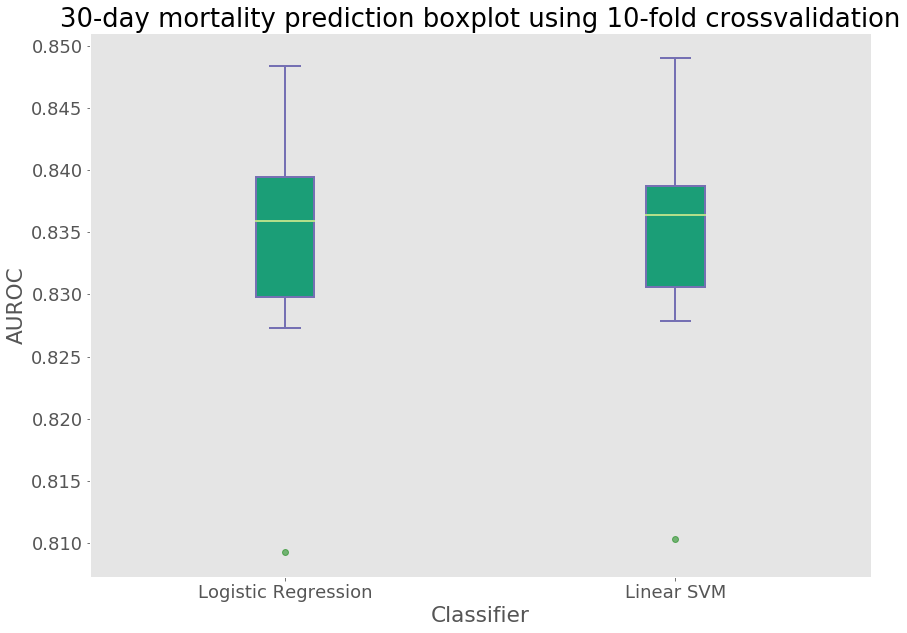

In [69]:
# styling taken from http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/
    
aucs = [results[clf] for clf in results]
data = np.array(aucs).T
xlabels = [clf for clf in results]

plt.figure(figsize=(14, 10))
bp = plt.boxplot(data, 0, 'gD', patch_artist=True)
plt.ylabel('AUROC')
plt.xlabel('Classifier')
plt.xticks([1, 2], [ 'Logistic Regression', 'Linear SVM',])
plt.title('30-day mortality prediction boxplot using 10-fold crossvalidation')
plt.grid(b=False)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
plt.show()

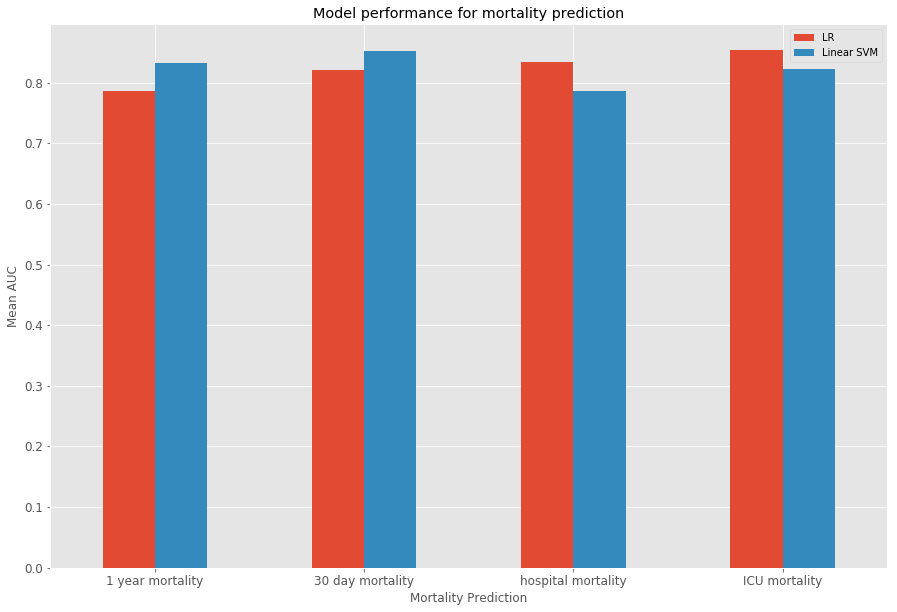

In [130]:
lr_df = pd.DataFrame(lr_results).describe().loc['mean', :]
svm_df = pd.DataFrame(svm_results).describe().loc['mean', :]
results_df = pd.concat((lr_df, svm_df), axis=1, keys=['LR', 'Linear SVM'])
ax = results_df.plot.bar(figsize=(15,10), fontsize=12, title='Model performance for mortality prediction')
ax.set_ylabel('Mean AUC')
ax.set_xticklabels(['1 year mortality', '30 day mortality', 'hospital mortality', 'ICU mortality'], rotation=0)
ax.set_xlabel('Mortality Prediction')

## Length of stay

In [123]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) & (query_output.exclusion_first_stay == 0)]

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            
            'aniongap_min', 'aniongap_max',
            #'albumin_min', 'albumin_max',
            #'bands_min', 'bands_max',
            'bicarbonate_min', 'bicarbonate_max',
            #'bilirubin_min', 'bilirubin_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            #'lactate_min', 'lactate_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            #'ptt_min', 'ptt_max',
            #'inr_min', 'inr_max',
            #'pt_min', 'pt_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
            
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, los_names + feature_names]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)

#query_output = query_output.loc[:, los_names + feature_names].dropna().reset_index(drop=True)

outcomes = query_output.loc[:, los_names]
features = query_output.loc[:, query_output.columns.difference(los_names)]

X = features
y = outcomes['hosp_los']

print(len(query_output))
query_output.tail()

32290


,hosp_los,icu_los,age_icu_in,gender,first_careunit,admission_type,heartrate_min,heartrate_max,meanbp_min,meanbp_max,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
32285,9.2917,3.8486,70.826046,0,5,0,62.0,119.0,71.0,118.0,...,3.1,3.9,135.0,144.0,7.0,7.0,3.3,4.5,1,1995.0
32286,3.1743,3.1737,63.893494,0,2,1,60.0,95.0,57.0,79.0,...,3.5,3.9,139.0,143.0,16.0,31.0,5.3,8.6,0,1400.0
32287,2.2396,1.2625,43.594414,0,0,1,58.0,80.0,49.0,105.0,...,3.8,4.1,139.0,140.0,12.0,13.0,11.7,11.8,0,1250.0
32288,9.0653,9.1439,86.957864,1,2,1,52.0,68.0,47.0,79.0,...,5.0,5.7,123.0,128.0,41.0,42.0,11.4,13.3,1,730.0
32289,1.6764,1.7034,77.488270,1,0,1,28.0,74.0,37.0,93.0,...,4.4,4.9,135.0,138.0,21.0,22.0,10.8,11.0,0,1800.0


In [124]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = RegressionLabels(np.array(y[:split]))
y_test = RegressionLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 22603)
('Number of testing samples:', 9687)


In [125]:
preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

True

In [126]:
%%time

# Load models
ls = LeastSquaresRegression(X_train, y_train)

tau = 1
rr = LinearRidgeRegression(tau, X_train, y_train)

# Train
ls.train()
rr.train()

metric = MeanSquaredError()

y_pred = ls.apply_regression(X_test)
mse = metric.evaluate(y_pred, y_test)
print("Least square regression MSE:", mse)
y_pred = rr.apply_regression(X_test)
mse = metric.evaluate(y_pred, y_test)
print("Linear ridge regression MSE:", mse)

('Least square regression MSE:', 107.92233811641616)
('Linear ridge regression MSE:', 107.92209858555722)
CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 122 ms


## With cross-validation

In [209]:
%%time

features = RealFeatures(np.array(X))
labels = RegressionLabels(np.array(y))

# Parameters to svm
k = 10
split = CrossValidationSplitting(labels, k)

metric = ROCEvaluation()
split.build_subsets()

classifiers = {'LSR': LeastSquaresRegression(), 'LLR': LinearRidgeRegression()}
tau = 1

regression_results = {}
total_regression_results = {}
total_regression_results['LSR'] = {}
total_regression_results['LLR'] = {}

print("Evaluating classifiers...")
for clf in classifiers:
    for outcome in los_names:
        y = outcomes[outcome]

        mses = []
        for i in range(k):    
            train_idx = split.generate_subset_inverse(i)
            test_idx = split.generate_subset_indices(i)
            X_train = RealFeatures(np.array(X.loc[train_idx]).T)
            y_train = RegressionLabels(np.array(y.loc[train_idx]))    
            X_test = RealFeatures(np.array(X.loc[test_idx]).T)
            y_test = RegressionLabels(np.array(y.loc[test_idx]))

            preprocessor = PruneVarSubMean(True)
            preprocessor.init(X_train)
            X_train.add_preprocessor(preprocessor)
            X_train.apply_preprocessor(True)

            preprocessor.init(X_test)
            X_test.add_preprocessor(preprocessor)
            X_test.apply_preprocessor(True)            
            
            if clf == 'LLR':
                classifiers[clf].set_tau(tau)

            classifiers[clf].set_features(X_train)
            classifiers[clf].set_labels(y_train)
            #ls = LeastSquaresRegression(X_train, y_train)

            classifiers[clf].train()

            metric = MeanSquaredError()

            y_pred = classifiers[clf].apply_regression(X_test)
            mse = metric.evaluate(y_pred, y_test)
            print("Fold %d, %s MSE:" % (i, clf), mse)
            mses.append(mse)
        regression_results[clf] = mses
        print('%s, Mean MSE across all folds:' % clf, np.mean(mses))
        total_regression_results[clf][outcome] = mses

Evaluating classifiers...
('Fold 0, LLR MSE:', 123.14707663803662)
('Fold 1, LLR MSE:', 218.76197058101235)
('Fold 2, LLR MSE:', 132.19235132882204)
('Fold 3, LLR MSE:', 214.47576622886518)
('Fold 4, LLR MSE:', 126.87365677624723)
('Fold 5, LLR MSE:', 191.97325104434447)
('Fold 6, LLR MSE:', 121.41371100028189)
('Fold 7, LLR MSE:', 204.93535590872125)
('Fold 8, LLR MSE:', 105.0355168232976)
('Fold 9, LLR MSE:', 219.15543036717736)
('LLR, Mean MSE across all folds:', 165.7964086696806)
('Fold 0, LLR MSE:', 43.393979516009594)
('Fold 1, LLR MSE:', 51.49980387796017)
('Fold 2, LLR MSE:', 36.21871723318467)
('Fold 3, LLR MSE:', 51.25985623839884)
('Fold 4, LLR MSE:', 42.88844294421598)
('Fold 5, LLR MSE:', 50.10696086765943)
('Fold 6, LLR MSE:', 37.751154737327454)
('Fold 7, LLR MSE:', 53.311423158990856)
('Fold 8, LLR MSE:', 31.99843901048221)
('Fold 9, LLR MSE:', 49.78290658035766)
('LLR, Mean MSE across all folds:', 44.82116841645869)
('Fold 0, LSR MSE:', 123.14705080805079)
('Fold 1, L